In [152]:
import pden
import pden.Net
import pden.Operations
import pden.PDENet

import tensorflow as tf

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import clear_output

%load_ext autoreload
%autoreload 1

%aimport pden.Net
%aimport pden.Operations
%aimport pden.PDENet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
def der(y, x, y_shape: int, x_shape: int):
    ys = tf.split(y, [1] * y_shape, 1)
    def _der(i, j=[]):
        f = ys[i]
        for _j in j:
            fs = tf.gradients(f, x)[0]
            f  = tf.split(fs, [1] * x_shape, 1)[_j]        
        return f
    return _der

In [273]:
N = 4
net_cos = pden.Net.BasicNet(
    pden.Operations.Linear(feature_out=N, random_init = True),
    pden.Operations.ActivationFunction(tf.cos),
    pden.Operations.Linear(feature_in=N, feature_out=1, random_init = True)
)

net_sin = pden.Net.BasicNet(
    pden.Operations.Linear(feature_out=N, random_init = True),
    pden.Operations.ActivationFunction(tf.sin),
    pden.Operations.Linear(feature_in=N, feature_out=1, random_init = True)
)

pnet_sin = pden.PDENet.PDENET(net=net_sin)
pnet_cos = pden.PDENet.PDENET(net=net_cos)

print(net_cos)
print(net_sin)

Net 30:
	19	Linear: [1 -> 4]
	12	Activation funciton: <function cos at 0x11717d710>
	24	Linear: [4 -> 1]
Net 6:
	7	Linear: [1 -> 4]
	13	Activation funciton: <function sin at 0x1171b7320>
	12	Linear: [4 -> 1]


In [274]:
x = tf.placeholder(tf.float64, [None, 1])
COS = pnet_cos.forward(x)
SIN = pnet_sin.forward(x)
y = COS + SIN

init_x = tf.placeholder(tf.float64, [1, 1])
init_COS = pnet_cos.forward(init_x)
init_SIN = pnet_sin.forward(init_x)
init_y = init_COS + init_SIN

bc_x = tf.placeholder(tf.float64, [1, 1])
bc_COS = pnet_cos.forward(bc_x)
bc_SIN = pnet_sin.forward(bc_x)
bc_y = bc_COS + bc_SIN

der_gen = der(y, x, 1, 1)
dy = der_gen(0, j=[0])

In [275]:
pnet_cos = pnet_cos.add_loss(tf.reduce_mean(tf.pow(dy - 2 * x, 2)))
pnet_cos = pnet_cos.add_loss(tf.reduce_mean(tf.pow(bc_y - 1.0, 2)), weight=15.0)
pnet_cos = pnet_cos.add_loss(tf.reduce_mean(tf.pow(init_y - 0.0, 2)), weight=15.0)

pnet_sin = pnet_sin.add_loss(tf.reduce_mean(tf.pow(dy * tf.pow(y, 2) - 2 * x * tf.pow(x, 2), 2)))
pnet_sin = pnet_sin.add_loss(tf.reduce_mean(tf.pow(bc_y - 1.0, 2)), weight=15.0)
pnet_sin = pnet_sin.add_loss(tf.reduce_mean(tf.pow(init_y - 0.0, 2)), weight=15.0)

In [276]:
learning_rate = 5e-2
training_epochs = 2501
display_step = 250

opt = tf.train.AdamOptimizer(learning_rate = learning_rate)
train = opt.minimize(pnet_cos.loss + pnet_sin.loss)

init = tf.global_variables_initializer()

In [277]:
X = np.linspace(0, 1, 50).reshape(-1, 1)

Training error for net is "0.0033118968916864017". Epoch 2500


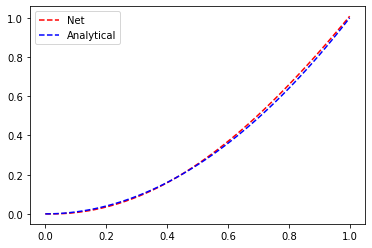

Optimization Finished!


In [278]:
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    
#     P = np.random.uniform(0, 0.5, size=(1,))
    
    _, l, Y = sess.run([train, pnet_cos.loss, y], feed_dict={
        x: X,
        init_x: np.array([[0.0]]),
        bc_x: np.array([[1.0]])
    })
    
    if epoch % display_step == 0:
        clear_output(wait=True)
        
        print(f'Training error for net is "{l}". Epoch {epoch}')
        
        plt.plot(X.flatten(), Y.flatten(), '--r', label='Net')
        plt.plot(X.flatten(), X.flatten() ** 2, '--b', label='Analytical')
        plt.legend()
        plt.show()

        
print("Optimization Finished!")